In [14]:
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import numpy as np
import os
from datetime import datetime

from numpy import interp
from sklearn.metrics import auc, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

import pandas as pd



In [2]:
def read_json(fn: str) -> dict:
    with open(fn, 'r') as f:
        data = json.load(f)
    return data

def read_text(fn: str) -> list:
    with open(fn, 'r') as f:
        data = f.readlines()
    return [_.strip() for _ in data]

def read_csv(fn: str) -> pd.DataFrame:
    df = pd.read_csv(fn)
    return df


## Let's set up the filepaths required for the ROC curve for the self-supervised experiments

In [3]:
# fps = {
#     "method": {
#         "submethod": ["fp 1", "fp2", "fp3", "fp4", "fp5"]
#     }
# }

# method_colors = {
#     "method-submethod": "color"
# }

fps = {
    "byol": {
        "400-5": ["logs/pretrain/1136", "logs/pretrain/1137", "logs/pretrain/1139"],
        "400-35": ["logs/pretrain/1145", "logs/pretrain/1144", "logs/pretrain/1143", "logs/pretrain/1142", "logs/pretrain/1146"],
        "4000-5": ["logs/pretrain/1154", "logs/pretrain/1156", "logs/pretrain/1155", "logs/pretrain/1158", "logs/pretrain/1157"],
        "4000-35": ["logs/pretrain/1149", "logs/pretrain/1151", "logs/pretrain/1150", "logs/pretrain/1152", "logs/pretrain/1153"]
    },
    "imagenet": {
        "tuned": ["logs/pretrain/814", "logs/pretrain/813", "logs/pretrain/811", "logs/pretrain/812"]
    },
    "random": {
        "tuned": ["logs/pretrain/1396", "logs/pretrain/1398", "logs/pretrain/1404", "logs/pretrain/1403", "logs/pretrain/1402"]
    },
    "simclr":
    {
        "500-5": ["logs/pretrain/1406", "logs/pretrain/1408", "logs/pretrain/1405", "logs/pretrain/1409", "logs/pretrain/1407"],
        "500-35": ["logs/pretrain/1160", "logs/pretrain/1161", "logs/pretrain/1162", "logs/pretrain/1163", "logs/pretrain/1164"],
        "950-5": ["logs/pretrain/1413", "logs/pretrain/1412", "logs/pretrain/1410", "logs/pretrain/1411", "logs/pretrain/1414"],
        "950-35": ["logs/pretrain/1395", "logs/pretrain/1400", "logs/pretrain/1401", "logs/pretrain/1399", "logs/pretrain/1397"]

    }
}

method_colors = {
    'simclr-950-5': 'b--',
    'simclr-950-35': 'b',
    
    'simclr-500-5': 'y--',
    'simclr-500-35': 'y',
    
    'byol-400-5': 'g--',
    'byol-400-35': 'g',
    
    'byol-4000-5': 'c--',
    'byol-4000-35': 'c',
    
    'imagenet-tuned': 'm',
    
    'random-tuned': 'k'
}



## Aaaaand the BASIS-transfer experiment## And let's set up the paths for the TCGA-TP53 ROC experiment ## Aaaand the TCGA-HRD experiment 

In [4]:
fps = {
    "TCGA: TP53 prediction": {
        "Naive tile-supervised": {
            "Imagenet": ["logs/pretrain/814", "logs/pretrain/813", "logs/pretrain/811", "logs/pretrain/812"], # slurm-6524458_1-5.out :  
            "SimCLR": ["logs/pretrain/819", "logs/pretrain/818", "logs/pretrain/816", "logs/pretrain/817", "logs/pretrain/815"] # slurm-6525915_1-5.out :  
        },
        "DeepMIL": {
            "SimCLR": ["logs/pretrain/793", "logs/pretrain/795", "logs/pretrain/792", "logs/pretrain/794", "logs/pretrain/796"], # slurm-6524254_1-5.out : "/logs/pretrain/793", "/logs/pretrain/795", "/logs/pretrain/792", "/logs/pretrain/794", "/logs/pretrain/796"
            "var-SimCLR": ["logs/eval/1298", "logs/eval/1305", "logs/eval/1307", "logs/eval/1304", "logs/eval/1306"] # slurm-6643408_1.out slurm-6643829_2-5 : eval ", "/logs/eval/1298", "/logs/eval/1305", "/logs/eval/1307", "/logs/eval/1304", "/logs/eval/1306"
            }
    },
    "TCGA: HRD prediction": {
        "Naive tile-supervised": {
            "Imagenet": ["logs/pretrain/777", "logs/pretrain/778",  "logs/pretrain/779", "logs/pretrain/780", "logs/pretrain/776"], # slurm-6524096_1-5.out :  
            "SimCLR": ["logs/pretrain/807", "logs/pretrain/804", "logs/pretrain/806", "logs/pretrain/805", "logs/pretrain/782"] #  slurm-6524297_1-4 slurm-6524159_5 :  :  
    },
        "DeepMIL": {
            "SimCLR": ["logs/pretrain/771", "logs/pretrain/772", "logs/pretrain/773", "logs/pretrain/774", "logs/pretrain/775"], #  logs/pretrain/771, logs/pretrain/772, logs/pretrain/773, logs/pretrain/774, logs/pretrain/775
            "var-SimCLR": ["logs/eval/1308", "logs/eval/1310", "logs/eval/1312", "logs/eval/1309", "logs/eval/1311"] # slurm-6643836_1-5:   
    }
    },
    "BASIS: HRD prediction": {
        "Naive tile-supervised": {
            "Imagenet-Direct": ["logs/pretrain/1706", "logs/pretrain/1707", "logs/pretrain/1708", "logs/pretrain/1709", "logs/pretrain/1710"], # slurm-6802848_1 :   
            "TCGA-SimCLR-Direct": ["logs/pretrain/1690", "logs/pretrain/1691", "logs/pretrain/1692", "logs/pretrain/1693", "logs/pretrain/1694"] # slurm-6801933 slurm-6801987 slurm-6801990 slurm-6801992 slurm-6801995 :  
    },
        "DeepMIL": {
            "TCGA-SimCLR-direct": ["logs/eval/1683", "logs/eval/1684", "logs/eval/1685", "logs/eval/1686", "logs/eval/1687"], # "slurm-6801831_1 slurm-6801839_1 slurm-6801844_1 slurm-6801845_1 slurm-6801846_1" :  
            "TCGA-SimCLR-finetune": ["logs/eval/1347", "logs/eval/1346", "logs/eval/1345", "logs/eval/1343", "logs/eval/1344"], # slurm-6646758_1-5 :
            "var-TCGA-SimCLR-finetune": ["logs/eval/1341", "logs/eval/1338", "logs/eval/1339", "logs/eval/1342", "logs/eval/1340"], # slurm-6646516_1-5 :  
            "TCGA-BASIS-SimCLR-finetune": ["logs/eval/1784", "logs/eval/1786", "logs/eval/1785", "logs/eval/1788", "logs/eval/1787"] # slurm-6810482_1-5 :  
        }
    }
    
}
method_colors_all = {
    "TCGA: TP53 prediction": {
        "Naive tile-supervised-Imagenet": "b--",
        "Naive tile-supervised-SimCLR": "b",
        "DeepMIL-SimCLR": "g--",
        "DeepMIL-var-SimCLR": "g",
    },
    "TCGA: HRD prediction": {
        "Naive tile-supervised-Imagenet": "b--",
        "Naive tile-supervised-SimCLR": "b",
        "DeepMIL-SimCLR": "g--",
        "DeepMIL-var-SimCLR": "g"
    },
    "BASIS: HRD prediction": {
        "Naive tile-supervised-Imagenet-Direct": "g--",
        "Naive tile-supervised-TCGA-SimCLR-Direct": "g",
        "DeepMIL-TCGA-SimCLR-direct": "b--",
        "DeepMIL-TCGA-SimCLR-finetune": "b",
        "DeepMIL-var-TCGA-SimCLR-finetune": "r--",
        "DeepMIL-TCGA-BASIS-SimCLR-finetune": "r"        
    }
    
}

In [5]:
def get_fold(fps: dict, method: str, submethod: str, idx: int, plot_title: str) -> (list, list, str):
    
    root="/home/yonis/SimCLR-1/"
    fp = fps[plot_title][method][submethod][idx]
    files = os.listdir(os.path.join(root, fp))
    prediction_file = [i for i in files if i.startswith("regression_output")][0]
    prediction_df = read_csv(os.path.join(root, fp, prediction_file)).groupby("patient").mean()
    
    labels = list(prediction_df["labels"])
    preds = list(prediction_df["preds"])
    method_name = f"{method}-{submethod}"
    return (labels, preds, method_name)
    


In [6]:
get_fold(fps=fps, method="simclr", submethod="950-5", idx=0)

TypeError: get_fold() missing 1 required positional argument: 'plot_title'

In [58]:

def plot_auc(fps: dict, method: str, submethod: str, 
             plot_individual_curve: bool=True, new_plot: bool=True, 
             single_plot: bool=True,
             fig: matplotlib.figure.Figure=None, ax: matplotlib.axes.Axes=None,
             plot_title: str=""
            ) -> (matplotlib.figure.Figure, matplotlib.axes.Axes):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)


    if new_plot or (not fig and not ax):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='random', alpha=.8)
          
    for idx in range(len(fps[plot_title][method][submethod])):
        y_true, y_pred, method_name = get_fold(fps=fps, method=method, submethod=submethod, idx=idx, plot_title=plot_title)
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1.)
#         fpr, tpr, _ = precision_recall_curve(y_true, y_pred, pos_label=1.)
        roc_auc = auc(fpr, tpr)
#         roc_auc = average_precision_score(y_true, y_pred)
        if plot_individual_curve:
            plt.plot(fpr, tpr, label=f'fold_{idx} (auc = {roc_auc:.2f})')
        interp_tpr = interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    print(method_name)
    ax.plot(mean_fpr, mean_tpr, method_colors[method_name],
            label=f'{method_name}:(AUC:%0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=1, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=method_colors[method_name][0], alpha=.1)
    
    if new_plot:
        ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
        title=f"Receiver operating characteristic for {plot_title}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
#         ax.set_yscale('log')
        ax.minorticks_on()
        plt.grid(b=True, which='both')
        
        
        if single_plot:
            plt.show()

    ax.legend(loc="lower right", prop={'size': 9})
    return fig, ax

    

{'TCGA: TP53 prediction': {'Naive tile-supervised': {'Imagenet': ['logs/pretrain/814', 'logs/pretrain/813', 'logs/pretrain/811', 'logs/pretrain/812'], 'SimCLR': ['logs/pretrain/819', 'logs/pretrain/818', 'logs/pretrain/816', 'logs/pretrain/817', 'logs/pretrain/815']}, 'DeepMIL': {'SimCLR': ['logs/pretrain/793', 'logs/pretrain/795', 'logs/pretrain/792', 'logs/pretrain/794', 'logs/pretrain/796'], 'var-SimCLR': ['logs/eval/1298', 'logs/eval/1305', 'logs/eval/1307', 'logs/eval/1304', 'logs/eval/1306']}}, 'TCGA: HRD prediction': {'Naive tile-supervised': {'Imagenet': ['logs/pretrain/777', 'logs/pretrain/778', 'logs/pretrain/779', 'logs/pretrain/780', 'logs/pretrain/776'], 'SimCLR': ['logs/pretrain/807', 'logs/pretrain/804', 'logs/pretrain/806', 'logs/pretrain/805', 'logs/pretrain/782']}, 'DeepMIL': {'SimCLR': ['logs/pretrain/771', 'logs/pretrain/772', 'logs/pretrain/773', 'logs/pretrain/774', 'logs/pretrain/775'], 'var-SimCLR': ['logs/eval/1308', 'logs/eval/1310', 'logs/eval/1312', 'logs/ev

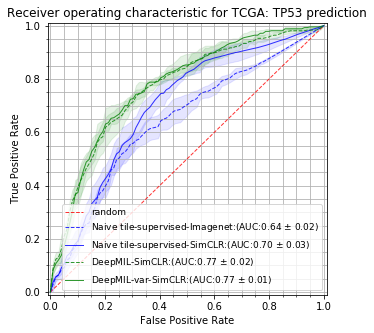

Naive tile-supervised-Imagenet
Naive tile-supervised-SimCLR
DeepMIL-SimCLR
DeepMIL-var-SimCLR


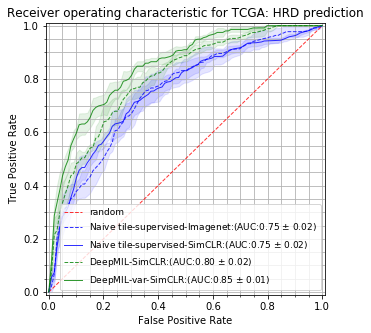

Naive tile-supervised-Imagenet-Direct
Naive tile-supervised-TCGA-SimCLR-Direct
DeepMIL-TCGA-SimCLR-direct
DeepMIL-TCGA-SimCLR-finetune
DeepMIL-var-TCGA-SimCLR-finetune
DeepMIL-TCGA-BASIS-SimCLR-finetune


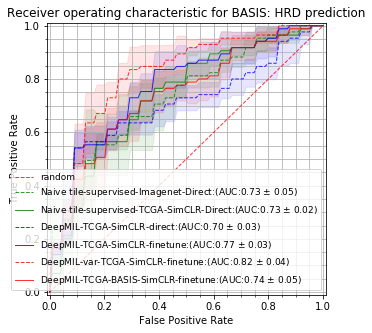

In [59]:
fig, ax = None, None
print(fps)
for plot_title in fps.keys():
    method_colors = method_colors_all[plot_title]
    for i, method in enumerate(fps[plot_title].keys()):
        for j, submethod in enumerate(fps[plot_title][method].keys()):
#         if submethod in ['400-35', '950-35'] or method in ['random', 'imagenet']:
            if fig == None and ax == None:
                fig, ax = plot_auc(fps=fps, method=method, submethod=submethod, plot_individual_curve=False, single_plot=False, plot_title=plot_title)
            else:
                fig, ax = plot_auc(fps=fps, method=method, submethod=submethod, plot_individual_curve=False, new_plot=False, fig=fig, ax=ax, plot_title=plot_title)

#     plt.savefig(f"report--results-{plot_title.replace(':','-').replace(' ', '-')}-roc-auc-curves-{datetime.datetime.now().ctime().replace(' ', '-').replace(':', '-')}.png")
    plt.show()
    
    fig = None
    ax = None
import datetime


# plot_auc(fps=fps_self_supervised, method="simclr", submethod="950-35")

In [56]:
datetime.datetime.now().ctime().replace(' ', '-').replace(':', '-')

'Tue-Dec-15-16-32-53-2020'